In [1]:
from pathlib import Path

import numpy as np

# import fullwave_simulation
from fullwave_simulation.conditions import PlaneWaveInitialCondition
from fullwave_simulation.constants.constant import Constant

# from fullwave_simulation.constants import FSASimulationParams, MaterialProperties
from fullwave_simulation.domains import (
    AbdominalWall,
    Background,
    DomainOrganizer,
    PhatomLateral,
    Scatterer,
)
from fullwave_simulation.solvers import FullwaveSolver
from fullwave_simulation.transducers import (  # C52VTransducer,; L74Transducer,
    L125Transducer,
    LinearTxWaveTransmitter,
    SignalReceiver,
)
from fullwave_simulation.transducers.linear_receiver_map import LinearReceiverMap
from fullwave_simulation.transducers.linear_transmitter_map import LinearTransmitterMap
from fullwave_simulation.transducers.whole_map_receiver import WholeMapReceiver
from fullwave_simulation.utils import MapViewer
from fullwave_simulation.utils.genout_reader import GenoutReader
from fullwave_simulation.utils.plot_utils import (
    plot_wave_propagation_animation,
    plot_wave_propagation_with_map,
)
from fullwave_simulation.utils.utils import power_compress


class SimulationParams(Constant):
    # dummy parameter for a plane wave imaging
    focal_depth = 3e-2
    # actual spacing of L12-5 50mm = 0.1953e-4 [m]
    spacing_m = 1.953e-4
    # number of active txducer elements (each emit)
    txducer_aperture = 64
    # walking aperture, sequential txrx events
    nelements = 192
    # nevents = nelements - txducer_aperture

    # --- Basic variables / parameters ---
    # speed of sound (m/s)
    c0 = 1540  # [m/s]
    # frequency [MHz]
    # f0 = 6.25e6
    f0 = 1e6  # [Hz]
    # pressure in Pa.
    p0 = 1e5  # [Pa]

    # number of points per spatial wavelength
    ppw = 12
    # Courant-Friedrichs-Levi condition
    cfl = 0.4

    # width of simulation field (m). lateral dimension.
    wX = 3.0e-2  # [m]
    # depth of simulation field (m)
    wY = 5.0e-2  # [m]

    # duration of simulation (s).
    # the time how much you want to simulate the propagation (sec)
    dur = wY * 2.3 / c0

    # --- initial conditions ---
    # number of cycles in pulse
    ncycles = 2
    # exponential drop-off of envelope
    drop_off = 2

    # plane wave sequences
    n_angles = 11
    f_number = 1

    # --- aliases ---
    width = wX
    depth = wY
    modT = 7
    num_cycles = ncycles
    nevents = n_angles

    is_fsa = False
    d_theta = 1.75 * np.pi / 180

    @property
    def omega0(self):
        return 2 * np.pi * self.f0

    @property
    def lambda_(self):
        return self.c0 / self.f0


class MaterialProperties(Constant):
    fat = {"bovera": 9.6, "alpha": 0.48, "ppower": 1.1, "c0": 1478, "rho0": 950}
    fat["beta"] = 1 + fat["bovera"] / 2

    liver = {"bovera": 7.6, "alpha": 0.5, "ppower": 1.0, "c0": 1570, "rho0": 1064}
    liver["beta"] = 1 + liver["bovera"] / 2

    muscle = {"bovera": 9, "alpha": 1.09, "ppower": 1.0, "c0": 1547, "rho0": 1050}
    muscle["beta"] = 1 + muscle["bovera"] / 2

    water = {"bovera": 5, "alpha": 0.005, "ppower": 2.0, "c0": 1480, "rho0": 1000}
    water["beta"] = 1 + water["bovera"] / 2

    skin = {"bovera": 8, "alpha": 2.1, "ppower": 1, "c0": 1498, "rho0": 1000}
    skin["beta"] = 1 + skin["bovera"] / 2

    tissue = {"bovera": 9, "alpha": 0.5, "ppower": 1, "c0": 1540, "rho0": 1000}
    tissue["beta"] = 1 + tissue["bovera"] / 2

    connective = {"bovera": 8, "alpha": 1.57, "ppower": 1, "c0": 1613, "rho0": 1120}
    connective["beta"] = 1 + connective["bovera"] / 2

    blood = {"bovera": 5, "alpha": 0.005, "ppower": 2.0, "c0": 1520, "rho0": 1000}
    blood["beta"] = 1 + blood["bovera"] / 2

    lung_fluid = {"bovera": 5, "alpha": 0.005, "ppower": 2.0, "c0": 1440, "rho0": 1000}
    lung_fluid["beta"] = 1 + lung_fluid["bovera"] / 2

    lung_air = {"bovera": 5, "alpha": 0.005, "ppower": 2.0, "c0": 340, "rho0": 1000}
    lung_air["beta"] = 1 + lung_air["bovera"] / 2

    c0 = 1540
    rho0 = 1000
    a0 = 0.5
    beta0 = 0


class LinearTransmitterMapMod(LinearTransmitterMap):
    def _calculate_inmap(self) -> np.ndarray:
        in_map = np.zeros((self.num_x, self.num_y))
        in_map[:, 0:8] = 1  # changed the input layer num
        return in_map


class L125TransducerMod(L125Transducer):
    def _make_transducer_surface_map(self, nX, nY):
        transmitter_map = LinearTransmitterMapMod(
            num_x=nX,
            num_y=nY,
            ppw=self.ppw,
            material_properties=self.material_properties,
            simulation_params=self.simulation_params,
        )
        # receiver_map = LinearReceiverMap(
        #     num_x=nX,
        #     num_y=nY,
        #     beam_spacing=self.beam_spacing,
        #     in_map=transmitter_map.in_map,
        #     ppw=self.ppw,
        #     material_properties=self.material_properties,
        #     simulation_params=self.simulation_params,
        # )
        receiver_map = WholeMapReceiver(
            num_x=nX,
            num_y=nY,
        )
        return transmitter_map, receiver_map

In [14]:
# Define your work directory and make the directory.
home_dir = Path(r'P:\smerino\fullwave_python')
work_dir = home_dir / "outputs" / "exp_dir_20240603_test"
work_dir.mkdir(exist_ok=True, parents=True)

# Set the parameters with fullwave_simulation.constants classes.
simulation_params = SimulationParams()
material_properties = MaterialProperties()

# Define the transducer properties using class in `fullwave_simulation.transducers`.
l125_transducer = L125TransducerMod(simulation_params, material_properties)

# Now, define the wave transmitter and signal receiver.
# WaveTransmitter is used to calculate the transmission pulse.
# SignalReceiver does not have an effect at the moment.
wave_transmitter = LinearTxWaveTransmitter(
    l125_transducer,
    simulation_params=simulation_params,
    material_properties=material_properties,
    is_fsa=simulation_params.is_fsa,
)
# --- animatin plot exmaple---

genout_reader = GenoutReader()
genout = genout_reader.load_and_reshape_from_path(
    genout_data_path= work_dir/"6"/"genout.dat",
    num_x=l125_transducer.num_x,
    num_y=l125_transducer.num_y,
    num_t=wave_transmitter.nT2 - 1,
)



In [21]:
import matplotlib.pyplot as plt

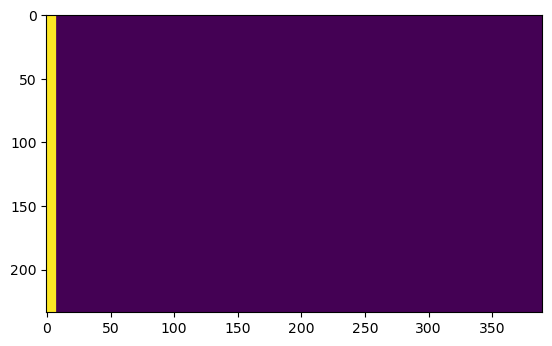

In [27]:
plt.imshow(l125_transducer.inmap)
plt.show()

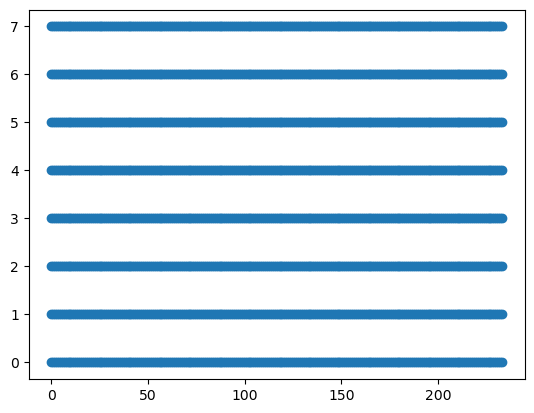

In [24]:
plt.scatter(l125_transducer.inmap[:,0],l125_transducer.incoords[:,1])
plt.show()

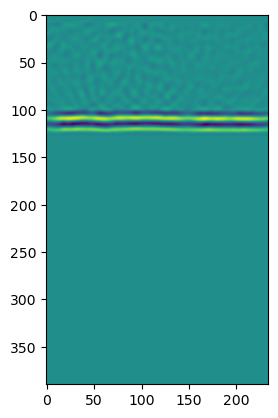

In [ ]:
plt.imshow(genout[50,:,:])
plt.show()

In [ ]:
genout